In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split


In [65]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("Device:", DEVICE)

# DATA_DIR = "/kaggle/input/chest-ct-segmentation"
# IMAGE_DIR = os.path.join(DATA_DIR, "/kaggle/input/chest-ct-segmentation/images/images")
# MASK_DIR  = os.path.join(DATA_DIR, "/kaggle/input/chest-ct-segmentation/masks/masks")


In [66]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

IMAGE_DIR = "/kaggle/input/brain-tumor-segmentation-1/brain tumor segmentation/image"
MASK_DIR  = "/kaggle/input/brain-tumor-segmentation-1/brain tumor segmentation/masks"


Device: cuda


In [67]:
images = sorted([
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

masks = sorted([
    os.path.join(MASK_DIR, f)
    for f in os.listdir(MASK_DIR)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

print("Images:", len(images))
print("Masks :", len(masks))


Images: 2192
Masks : 2192


In [68]:
min_len = min(len(images), len(masks))

images = images[:min_len]
masks  = masks[:min_len]

print("Paired samples:", len(images))


Paired samples: 2192


In [69]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    images,
    masks,
    test_size=0.2,
    random_state=42
)

print("Train:", len(train_imgs))
print("Val  :", len(val_imgs))


Train: 1753
Val  : 439


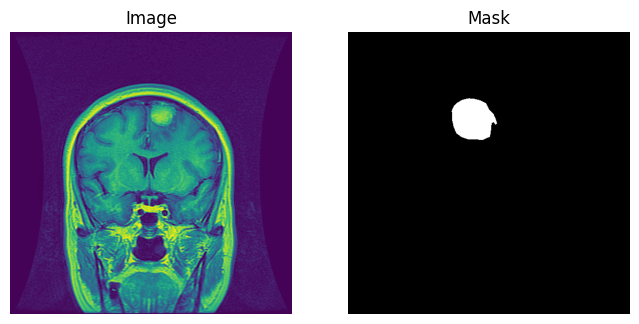

In [70]:
import matplotlib.pyplot as plt
from PIL import Image

img  = Image.open(train_imgs[0])
mask = Image.open(train_masks[0])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [71]:
# images = sorted([
#     os.path.join(IMAGE_DIR, f)
#     for f in os.listdir(IMAGE_DIR)
#     if f.endswith(('.png', '.jpg', '.jpeg'))
# ])

# masks = sorted([
#     os.path.join(MASK_DIR, f)
#     for f in os.listdir(MASK_DIR)
#     if f.endswith(('.png', '.jpg', '.jpeg'))
# ])

# print("Total Images:", len(images))
# print("Total Masks :", len(masks))


In [72]:
# image_files = set([
#     f for f in os.listdir(IMAGE_DIR)
#     if f.endswith(('.png', '.jpg', '.jpeg'))
# ])

# mask_files = set([
#     f for f in os.listdir(MASK_DIR)
#     if f.endswith(('.png', '.jpg', '.jpeg'))
# ])

# common_files = sorted(image_files.intersection(mask_files))

# print("Paired samples:", len(common_files))

# images = [os.path.join(IMAGE_DIR, f) for f in common_files]
# masks  = [os.path.join(MASK_DIR, f) for f in common_files]


In [73]:
# train_imgs, val_imgs, train_masks, val_masks = train_test_split(
#     images,
#     masks,
#     test_size=0.2,
#     random_state=42
# )

# print("Train:", len(train_imgs))
# print("Val  :", len(val_imgs))


In [74]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [75]:
# class ChestCTDataset(Dataset):
#     def __init__(self, images, masks, transform=None):
#         self.images = images
#         self.masks = masks
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img = Image.open(self.images[idx]).convert("RGB")
#         mask = Image.open(self.masks[idx]).convert("L")

#         if self.transform:
#             img = self.transform(img)
#             mask = self.transform(mask)

#         mask = (mask > 0).float()   # binary mask
#         return img, mask


In [76]:
class ChestCTDataset(Dataset):
    def __init__(self, images, masks, img_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img  = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")

        if self.img_transform:
            img = self.img_transform(img)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0).float()  # binary mask
        return img, mask


In [77]:
# images = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)])
# masks  = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)])

# train_imgs, val_imgs, train_masks, val_masks = train_test_split(
#     images, masks, test_size=0.2, random_state=42
# )

# print("Train:", len(train_imgs), "Val:", len(val_imgs))


In [78]:
train_dataset = ChestCTDataset(
    train_imgs, train_masks,
    img_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = ChestCTDataset(
    val_imgs, val_masks,
    img_transform=image_transform,
    mask_transform=mask_transform
)


In [79]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])


In [80]:
# train_dataset = ChestCTDataset(train_imgs, train_masks, transform)
# val_dataset   = ChestCTDataset(val_imgs, val_masks, transform)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [81]:
class VGG16_Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.block4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
        )

        self.block5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
        )

    def forward(self, x):
        e1 = self.block1(x)
        e2 = self.block2(e1)
        e3 = self.block3(e2)
        e4 = self.block4(e3)
        e5 = self.block5(e4)
        return e1, e2, e3, e4, e5


In [82]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key   = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        Q = self.query(x).view(B, -1, H*W)
        K = self.key(x).view(B, -1, H*W)
        V = self.value(x).view(B, -1, H*W)

        attn = torch.softmax(torch.bmm(Q.permute(0,2,1), K), dim=-1)
        out = torch.bmm(V, attn.permute(0,2,1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x


In [83]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.ReLU(),
            nn.Linear(dim*4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H*W).permute(0,2,1)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(attn_out + x)
        ffn_out = self.ffn(x)
        x = self.norm2(ffn_out + x)
        return x.permute(0,2,1).view(B, C, H, W)


In [84]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


In [85]:
class VGG_Attn_Transformer_UNetPP(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        self.encoder = VGG16_Encoder()
        self.attn = SelfAttention(512)
        self.transformer = TransformerBlock(512)

        self.d4 = DecoderBlock(512, 512, 256)
        self.d3 = DecoderBlock(256, 256, 128)
        self.d2 = DecoderBlock(128, 128, 64)
        self.d1 = DecoderBlock(64, 64, 32)

        self.final = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        e1, e2, e3, e4, e5 = self.encoder(x)
        x = self.attn(e5)
        x = self.transformer(x)
        x = self.d4(x, e4)
        x = self.d3(x, e3)
        x = self.d2(x, e2)
        x = self.d1(x, e1)
        return self.final(x)


In [86]:
model = VGG_Attn_Transformer_UNetPP().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [87]:
def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    return (2*inter + smooth) / (pred.sum() + target.sum() + smooth)


In [88]:
def train_epoch(loader):
    model.train()
    total = 0
    for img, mask in loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        pred = model(img)
        loss = criterion(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

def validate(loader):
    model.eval()
    total_loss, total_dice = 0, 0
    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            pred = model(img)
            total_loss += criterion(pred, mask).item()
            total_dice += dice_score(pred, mask).item()
    return total_loss/len(loader), total_dice/len(loader)


In [ ]:
EPOCHS = 25
best_dice = 0

for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    val_loss, val_dice = validate(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model Saved")


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

img, _ = val_dataset[0]
img = img.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = torch.sigmoid(model(img))

print(pred.shape)  # (1, 1, 224, 224)
